# **1. Theory Questions:**
### Q1: Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.
The minimax loss function in GANs models the adversarial game between the generator (G) and discriminator (D). It is defined as:

  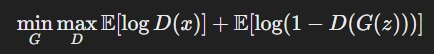

  D aims to maximize this loss by correctly classifying real and fake samples, while G tries to minimize it by generating realistic samples to fool D. This competitive process ensures both networks improve iteratively—D becomes better at distinguishing real from fake, while G generates increasingly realistic data, leading to a Nash equilibrium where G produces highly realistic outputs.


###   Q2: What is mode collapse, Why can mode collapse occur during GAN training? and how can it be mitigated?

  Mode collapse in GANs occurs when the generator produces a limited set of repetitive outputs instead of capturing the full data distribution. This happens when the generator exploits weaknesses in the discriminator, learning to produce only a few patterns that consistently fool it. The issue arises due to imbalanced training, instability in optimization, or lack of diversity in updates. To mitigate mode collapse, techniques such as minibatch discrimination, feature matching, Wasserstein GANs (WGAN), unrolled GANs, and label smoothing can be used. These methods encourage the generator to produce more diverse outputs, stabilize training, and prevent it from converging to a narrow subset of the data distribution.

###   Q3: Explain the role of the discriminator in adversarial training?

The discriminator in adversarial training acts as a classifier that distinguishes between real and fake data. It guides the generator by providing feedback on how realistic the generated samples are. During training, the discriminator learns to maximize its accuracy in differentiating real from fake data, while the generator learns to produce samples that can fool it. This adversarial process drives both networks to improve iteratively. A well-trained discriminator helps the generator refine its outputs, ensuring the generation of realistic samples. However, if the discriminator becomes too strong, it can overpower the generator, hindering learning and causing instability in training.


###  Q4: How do metrics like IS and FID evaluate GAN performance?

Inception Score (IS) and Fréchet Inception Distance (FID) are commonly used metrics to evaluate GAN performance. IS measures the quality and diversity of generated images using a pre-trained Inception network, where higher scores indicate better diversity and realism. However, IS does not compare generated images to real data. In contrast, FID calculates the distance between real and generated image distributions using feature representations from an Inception model. A lower FID score suggests that generated images are more similar to real ones, making it a more reliable evaluation metric. FID is generally preferred as it captures both quality and diversity while considering real data distribution.


# **2.Coding Assignment:**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Check GPU availability (optional)
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.18.0
Num GPUs Available: 1


In [ ]:
# ===============================
# Step 1: Data Preparation
# ===============================
# The CIFAR-10 dataset will be automatically downloaded.
(x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()

# Convert to float32 and normalize images to [-1, 1]
x_train = x_train.astype('float32')
x_train = (x_train - 127.5) / 127.5

# Set up buffer and batch sizes.
BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 256

# Create a tf.data.Dataset for efficient loading and shuffling.
train_dataset = tf.data.Dataset.from_tensor_slices(x_train) \
                               .shuffle(BUFFER_SIZE) \
                               .batch(BATCH_SIZE)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [ ]:
# --- Generator Model ---
def make_generator_model():
    model = tf.keras.Sequential(name="generator")

    # Project the 100-dimensional noise vector to a 8x8x256 tensor.
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))  # Now shape: (8, 8, 256)

    # Upsample from 8x8 to 16x16 using a transposed convolution.
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # ---- Additional convolutional layer (feature refinement at 16x16) ----
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1),
                            padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample from 16x16 to 32x32.
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # ---- Additional convolutional layer at final resolution (32x32) ----
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1),
                            padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final convolution: produce a 32x32x3 image with tanh activation.
    model.add(layers.Conv2D(3, (5, 5), strides=(1, 1),
                            padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
# --- Discriminator Model ---
def make_discriminator_model():
    model = tf.keras.Sequential(name="discriminator")
    # Input shape is now 32x32x3 for CIFAR-10 images.
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [ ]:
# Instantiate the generator and discriminator.
generator = make_generator_model()
discriminator = make_discriminator_model()

# ===============================
# Step 3: Loss Functions and Optimizers
# ===============================
# We use binary cross-entropy for both generator and discriminator.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Label real images as 1.
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Label fake images as 0.
    return real_loss + fake_loss

def generator_loss(fake_output):
    # Generator tries to fool the discriminator, so it wants fake images to be labeled as 1.
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Set up optimizers.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# ===============================
# Step 4: Training Loop & Image Saving
# ===============================
# Fixed seed for image generation to track progress.
seed = tf.random.normal([16, 100])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
# Helper function to generate and save images.
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0  # Rescale to [0,1]

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}', fontsize=16)
    plt.tight_layout()

    os.makedirs('generated_images', exist_ok=True)
    plt.savefig(f'generated_images/image_at_epoch_{epoch:04d}.png')
    plt.close()

def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)

        print(f"Epoch {epoch}: Generator Loss: {g_loss:.4f}, Discriminator Loss: {d_loss:.4f}")

        if epoch % 10 == 0:
            generate_and_save_images(generator, epoch, seed)

# ===============================
# Step 5: Run the Training
# ===============================
EPOCHS = 50  # Change this as needed.
train(train_dataset, EPOCHS)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1: Generator Loss: 1.4053, Discriminator Loss: 1.1568
Epoch 2: Generator Loss: 2.3506, Discriminator Loss: 0.5504
Epoch 3: Generator Loss: 0.6790, Discriminator Loss: 1.8658
Epoch 4: Generator Loss: 1.1966, Discriminator Loss: 0.9988
Epoch 5: Generator Loss: 0.6639, Discriminator Loss: 1.1067
Epoch 6: Generator Loss: 0.8788, Discriminator Loss: 1.4929
Epoch 7: Generator Loss: 0.7602, Discriminator Loss: 1.4139
Epoch 8: Generator Loss: 0.7376, Discriminator Loss: 1.2846
Epoch 9: Generator Loss: 1.1558, Discriminator Loss: 1.1934
Epoch 10: Generator Loss: 0.8110, Discriminator Loss: 1.6904
Epoch 11: Generator Loss: 0.6287, Discriminator Loss: 1.2788
Epoch 12: Generator Loss: 1.1329, Discriminator Loss: 1.0679
Epoch 13: Generator Loss: 0.8582, Discriminator Loss: 1.2922
Epoch 14: Generator Loss: 0.7616, Discriminator Loss: 1.0742
Epoch 15: Generator Loss: 0.9922, Discriminator Loss: 1.0259
Epoch 16: Generator Loss: 0.9110, Discriminator Loss: 1.3182
Epoch 17: Generator Loss: 0.8719,


Displaying the final saved generated image:


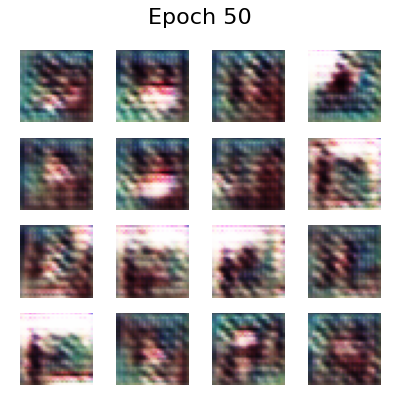

In [ ]:
# After training, you can display one of the saved images as follows:
from IPython.display import Image, display
import glob

image_files = sorted(glob.glob("generated_images/*.png"))
if image_files:
    print("\nDisplaying the final saved generated image:")
    display(Image(filename=image_files[-1]))
else:
    print("No generated images found.")